In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# separação de dados
from sklearn.model_selection import train_test_split

# padronização dos dados
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# construção de filtro para ColumnTransformer
from sklearn.compose import make_column_selector

# criação de pipeline para tratamento do conjunto de dados
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# modelo
from sklearn.linear_model import LassoCV, RidgeCV

In [2]:
dataframe_train = pd.read_csv('train.csv')

In [3]:
# agora uma função que vai printar bonitinho as métricas
def print_metrics(model: Pipeline, model_name: str, X_test: np.ndarray, y_test: np.ndarray, y_pred: np.ndarray) -> str:
  """
  Returns the Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE) and R-squared scores of the model
      
      Arguments:
          model_name {str} -- name of the model
          y_test {array} -- array of the test labels
          y_pred {array} -- array of the predicted labels
          y_test_pca {array} -- array of the test labels after PCA
          y_pred_pca {array} -- array of the predicted labels after PCA
      
      Returns:
          A formatted string containing the accuracy, precision and recall scores of the model for both non-PCA and PCA.
  
  """
  #imports
  from sklearn.metrics import mean_absolute_error, mean_squared_error

  return (f'''

Mean Absolute Error (MAE) do Modelo {model_name}: {mean_absolute_error(y_test, y_pred):.3f}

Mean Squared Error (MSE) do Modelo {model_name}: {mean_squared_error(y_test, y_pred, squared=True):.4f}

Root Mean Squared Error (RMSE) do Modelo {model_name}: {mean_squared_error(y_test, y_pred, squared=False):.4f}

R-squared do Modelo {model_name}: {model.score(X_test, y_test):.3f}
''')

In [4]:
def get_features(model: Pipeline, model_name: str, ispca: bool) -> str:
  """
  Get Features Function
  
  Returns a string containing the number of original features, the number of features selected by the model (in case the model is a Lasso) and the name of the features selected (will return all features if it's not a Lasso).
      
      Arguments:

          - model {Pipeline} -- a pipeline object containing an estimator/model with fit/transform/predict operations.

          - model_name {str} -- name of the model used inside the pipeline to identify the model

          - ispca {bool} -- if the model passed is a model with pca, this should be true, otherwise it should be false.
      
      Returns:
      
          Returns a string containing the number of original features, the number of features selected by the model (in case the model is a Lasso) and the name of the features selected (will return all features if it's not a Lasso).
  
  """

  preprocessor_fitted = model['preprocessor']
  
  if ispca:
    feature_names = (
      list(preprocessor_fitted.named_transformers_['num']['pca'].get_feature_names_out()) +
      list(preprocessor_fitted.named_transformers_['cat']['pca'].get_feature_names_out())
      )
  
  else:
    feature_names = (
      list(preprocessor_fitted.named_transformers_['num']['imputer'].get_feature_names_out()) +
      list(preprocessor_fitted.named_transformers_['cat']['one_hot_encoder'].get_feature_names_out())
      )
  feature_names = np.array(feature_names)
  kept = ~np.isclose(model[model_name].coef_, 0)
  
  if 'lasso' not in model_name:
    return(f'''
    Atenção: O modelo passado não é Lasso, logo todas as variáveis passadas terão sido selecionadas.
    Número de Features Original: {len(feature_names)}
    Número de Features selecionadas pelo {model_name}: {len(feature_names[kept])}
    Features Selecionadas:
    {feature_names[kept]}
    ''')

  return(f'''
    Número de Features Original: {len(feature_names)}
    Número de Features selecionadas pelo {model_name}: {len(feature_names[kept])}
    Features Selecionadas:
    {feature_names[kept]}
    ''')

### 1. Análise exploratória de dados (1.0 ponto)
Realize a análise exploratória de dados. Observe cada variável, como se comportam em relação a outras variáveis independentes e com a variável dependente.

Uma rapida analize dos dados 

In [5]:
print(f'Observando a quantidade de registros e a quantidade de atributos:')
print(f'\nTamanho do dataframe_train: {dataframe_train.shape}')

Observando a quantidade de registros e a quantidade de atributos:

Tamanho do dataframe_train: (1460, 81)


In [6]:
print('\nObservando as informações basicas do dataframe_train:')
dataframe_train.info()


Observando as informações basicas do dataframe_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 1

In [8]:
print("Missing Values by Column")
print("-"*30)
print(dataframe_train.isna().sum())
print("-"*30)
print("TOTAL MISSING VALUES:",dataframe_train.isna().sum().sum())
print('\nÉ temos muitas colunas com valores faltantes, isso vai ser um grande problema !!!')

Missing Values by Column
------------------------------
Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64
------------------------------
TOTAL MISSING VALUES: 6965

É temos muitas colunas com valores faltantes, isso vai ser um grande problema !!!


----

2. Levantamento de hipóteses (1.0 ponto)
Descreva quais hipóteses você observou ao fazer a análise exploratória de dados.

Só olhando, eu penso que o dataset vai tentar me dizer oque mais as pessoas procuram na hora de comprar uma casa, já que o dataset foi criado a partir disso, estranho né

-----

### 3. Apresentação das ideias obtidas (1.0 ponto)
Apresente com gráficos as suas observações e a descreva cada gráfico.


Fiz um HeatMap, eu sei que categoriza só numericos, mas não sei como iria transforma de objeto para numeral 

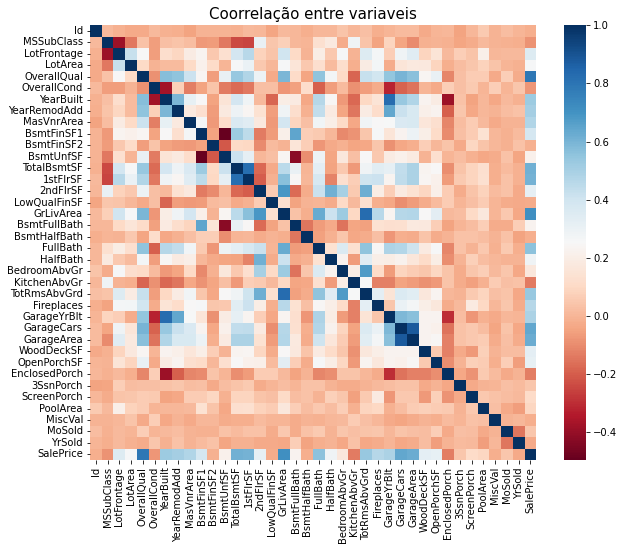

In [22]:
plt.figure(figsize=(10,8))
sns.heatmap(dataframe_train.corr(), cmap="RdBu")
plt.title("Coorrelação entre variaveis", size=15)
plt.show()


### 4. Preparação dos dados (1.0 ponto)
Faça um processamento nos dados, preenchendo valores faltantes, removendo dados ou variáveis inconsistentes e normalizado os dados

In [9]:
X = dataframe_train.drop(['SalePrice'], axis=1)
y = dataframe_train['SalePrice']

In [10]:
colum_num = make_column_selector(dtype_include=[np.number])
colum_tex = make_column_selector(dtype_include=[np.object])  

numeric_transformer = Pipeline(
  steps=[
          ("imputer", SimpleImputer(strategy="median")),
          ("scaler", StandardScaler())
        ]
)

categorical_transformer = Pipeline(
  steps=[
          ("imputer", SimpleImputer(strategy="constant", fill_value="0")),
          ("one_hot_encoder", OneHotEncoder(dtype=int, handle_unknown='ignore', drop='if_binary', sparse=False))
        ]
)

preprocessor = ColumnTransformer(
  transformers=[
    ("num", numeric_transformer, colum_num),
    ("cat", categorical_transformer, colum_tex)
  ]
)

model_lassoCV = Pipeline(
  steps=[
    ("preprocessor", preprocessor), 
    ("lassocv", LassoCV(cv=5))
  ]
)

model_lassoCV

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbfa0eb3c40>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='0',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 dtype=<class 'int'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbfa0eb3df0>)])),
                ('lassocv', LassoCV(cv=5))])

In [11]:

#Apenas serapando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# treinando o modelo
model_lassoCV.fit(X_train, y_train)
y_pred = model_lassoCV.predict(X_test)

In [12]:
print(get_features(model=model_lassoCV, model_name='lassocv', ispca= False))


    Número de Features Original: 300
    Número de Features selecionadas pelo lassocv: 90
    Features Selecionadas:
    ['Id' 'MSSubClass' 'LotFrontage' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2'
 'TotalBsmtSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath'
 'BsmtHalfBath' 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr'
 'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt' 'GarageCars' 'GarageArea'
 'WoodDeckSF' 'OpenPorchSF' '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal'
 'MoSold' 'x0_RM' 'x3_IR2' 'x4_Bnk' 'x4_HLS' 'x6_CulDSac' 'x7_Mod'
 'x8_BrkSide' 'x8_Crawfor' 'x8_Edwards' 'x8_Gilbert' 'x8_Mitchel'
 'x8_NAmes' 'x8_NWAmes' 'x8_NoRidge' 'x8_NridgHt' 'x8_Somerst'
 'x8_StoneBr' 'x9_Norm' 'x10_PosN' 'x11_1Fam' 'x11_2fmCon' 'x12_1Story'
 'x12_2Story' 'x13_Gable' 'x14_ClyTile' 'x15_BrkFace' 'x15_HdBoard'
 'x16_ImStucc' 'x16_Plywood' 'x17_BrkFace' 'x17_None' 'x18_Ex' 'x18_TA'
 'x20_BrkTil' 'x20_PConc' 'x21_Ex' 'x22_TA' 'x23_Gd'

In [13]:
print(f'Pontuação do Modelo: {print_metrics(model=model_lassoCV, model_name="Pipeline LassoCV", X_test=X_test, y_test=y_test, y_pred=y_pred)}')

Pontuação do Modelo: 

Mean Absolute Error (MAE) do Modelo Pipeline LassoCV: 17523.065

Mean Squared Error (MSE) do Modelo Pipeline LassoCV: 866285046.5730

Root Mean Squared Error (RMSE) do Modelo Pipeline LassoCV: 29432.7207

R-squared do Modelo Pipeline LassoCV: 0.887



## 5. Criação e seleção de características (1.0 ponto)
Observando as variáveis disponíveis, é possível criar novas variáveis? Ou trazer de um dado externo novos dados para agregar aos existentes? É possível selecionar uma variável ou grupo de variáveis que melhor explica a variável dependente?

In [14]:
# construindo pipeline para o modelo de regressão usando LassoCV

numeric_transformer_pca = Pipeline(
  steps=[
          ("imputer", SimpleImputer(strategy="median")),
          ("scaler", StandardScaler()),
          ("pca", PCA(n_components='mle'))
        ]
)

categorical_transformer_pca = Pipeline(
  steps=[
          ("imputer", SimpleImputer(strategy="constant", fill_value="0")),
          ("one_hot_encoder", OneHotEncoder(dtype=int, handle_unknown='ignore', drop='if_binary', sparse=False)),
          ("pca", PCA(n_components='mle'))
        ]
)

preprocessor = ColumnTransformer(
  transformers=[
    ("num", numeric_transformer_pca, colum_num),
    ("cat", categorical_transformer_pca, colum_tex)
  ]
)

model_lassoCV_pca = Pipeline(
  steps=[
    ("preprocessor", preprocessor), 
    ("lassocv", LassoCV(cv=5))
  ]
)

model_lassoCV_pca

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components='mle'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbfa0eb3c40>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='0',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 dtype=<class 'int'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('pca',
                                                                   PCA(n_components='mle'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbfa0eb3df0>)])),
                ('lassocv', LassoCV(cv=5))])

In [15]:
# fit e predict do modelo LassoCV com pca
model_lassoCV_pca.fit(X_train, y_train)
y_pred = model_lassoCV_pca.predict(X_test)

In [16]:
print(get_features(model=model_lassoCV_pca, model_name='lassocv', ispca= True))


    Número de Features Original: 250
    Número de Features selecionadas pelo lassocv: 108
    Features Selecionadas:
    ['pca0' 'pca1' 'pca2' 'pca3' 'pca4' 'pca5' 'pca6' 'pca7' 'pca8' 'pca9'
 'pca10' 'pca11' 'pca14' 'pca15' 'pca16' 'pca17' 'pca18' 'pca19' 'pca20'
 'pca22' 'pca23' 'pca24' 'pca25' 'pca26' 'pca27' 'pca28' 'pca29' 'pca31'
 'pca32' 'pca33' 'pca34' 'pca0' 'pca1' 'pca2' 'pca3' 'pca4' 'pca5' 'pca6'
 'pca7' 'pca8' 'pca9' 'pca10' 'pca12' 'pca13' 'pca14' 'pca15' 'pca16'
 'pca17' 'pca18' 'pca19' 'pca20' 'pca22' 'pca23' 'pca24' 'pca25' 'pca26'
 'pca27' 'pca29' 'pca32' 'pca33' 'pca34' 'pca35' 'pca36' 'pca39' 'pca40'
 'pca41' 'pca42' 'pca43' 'pca44' 'pca45' 'pca47' 'pca48' 'pca51' 'pca52'
 'pca53' 'pca55' 'pca56' 'pca57' 'pca59' 'pca60' 'pca61' 'pca62' 'pca64'
 'pca67' 'pca68' 'pca69' 'pca71' 'pca75' 'pca76' 'pca78' 'pca82' 'pca85'
 'pca86' 'pca88' 'pca89' 'pca94' 'pca96' 'pca98' 'pca99' 'pca102' 'pca104'
 'pca106' 'pca107' 'pca118' 'pca131' 'pca180' 'pca182' 'pca184']
    


In [17]:
# pontuações
print(f'Pontuação do Modelo: {print_metrics(model=model_lassoCV_pca, model_name="Pipeline LassoCV com PCA", X_test=X_test, y_test=y_test, y_pred=y_pred)}')

Pontuação do Modelo: 

Mean Absolute Error (MAE) do Modelo Pipeline LassoCV com PCA: 18956.904

Mean Squared Error (MSE) do Modelo Pipeline LassoCV com PCA: 978705610.2881

Root Mean Squared Error (RMSE) do Modelo Pipeline LassoCV com PCA: 31284.2710

R-squared do Modelo Pipeline LassoCV com PCA: 0.872



Testando o Pipeline com Ridge e pca

In [18]:
# construindo pipeline para o modelo de regressão usando Ridge

model_ridgeCV_pca = Pipeline(
  steps=[
    ("preprocessor", preprocessor), 
    ("ridgecv", RidgeCV(cv=5))
  ]
)

model_ridgeCV_pca

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components='mle'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbfa0eb3c40>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='0',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 dtype=<class 'int'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('pca',
                                                                   PCA(n_components='mle'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fbfa0eb3df0>)])),
                ('ridgecv', RidgeCV(cv=5))])

In [19]:
# fit e predict do modelo Ridge com pca
model_ridgeCV_pca.fit(X_train, y_train)
y_pred = model_ridgeCV_pca.predict(X_test)

In [20]:
print(get_features(model=model_ridgeCV_pca, model_name='ridgecv', ispca= True))


    Atenção: O modelo passado não é Lasso, logo todas as variáveis passadas terão sido selecionadas.
    Número de Features Original: 250
    Número de Features selecionadas pelo ridgecv: 250
    Features Selecionadas:
    ['pca0' 'pca1' 'pca2' 'pca3' 'pca4' 'pca5' 'pca6' 'pca7' 'pca8' 'pca9'
 'pca10' 'pca11' 'pca12' 'pca13' 'pca14' 'pca15' 'pca16' 'pca17' 'pca18'
 'pca19' 'pca20' 'pca21' 'pca22' 'pca23' 'pca24' 'pca25' 'pca26' 'pca27'
 'pca28' 'pca29' 'pca30' 'pca31' 'pca32' 'pca33' 'pca34' 'pca0' 'pca1'
 'pca2' 'pca3' 'pca4' 'pca5' 'pca6' 'pca7' 'pca8' 'pca9' 'pca10' 'pca11'
 'pca12' 'pca13' 'pca14' 'pca15' 'pca16' 'pca17' 'pca18' 'pca19' 'pca20'
 'pca21' 'pca22' 'pca23' 'pca24' 'pca25' 'pca26' 'pca27' 'pca28' 'pca29'
 'pca30' 'pca31' 'pca32' 'pca33' 'pca34' 'pca35' 'pca36' 'pca37' 'pca38'
 'pca39' 'pca40' 'pca41' 'pca42' 'pca43' 'pca44' 'pca45' 'pca46' 'pca47'
 'pca48' 'pca49' 'pca50' 'pca51' 'pca52' 'pca53' 'pca54' 'pca55' 'pca56'
 'pca57' 'pca58' 'pca59' 'pca60' 'pca61' 'pca62' '

In [21]:
# pontuações
print(f'Pontuação do Modelo: {print_metrics(model=model_ridgeCV_pca, model_name="Pipeline RidgeCV com PCA", X_test=X_test, y_test=y_test, y_pred=y_pred)}')

Pontuação do Modelo: 

Mean Absolute Error (MAE) do Modelo Pipeline RidgeCV com PCA: 19171.747

Mean Squared Error (MSE) do Modelo Pipeline RidgeCV com PCA: 934734415.2342

Root Mean Squared Error (RMSE) do Modelo Pipeline RidgeCV com PCA: 30573.4266

R-squared do Modelo Pipeline RidgeCV com PCA: 0.878



----

## 5. Criação e seleção de características (1.0 ponto)
Observando as variáveis disponíveis, é possível criar novas variáveis?<br>
    R : Não sei criar novas

Ou trazer de um dado externo novos dados para agregar aos existentes?<br>
    R : Sim, é possivel pois o dataSet não tem cidades ou estado! 

É possível selecionar uma variável ou grupo de variáveis que melhor explica a variável dependente? <br>
    R : Vou deixar em baixo as variaveis escolhidas pelo Lasso com peso maior que Zero !!

Número de Features Original: 300 <br>
    Número de Features selecionadas pelo lassocv: 90 <br>
    Features Selecionadas: <br>
    ['Id' 'MSSubClass' 'LotFrontage' 'LotArea' 'OverallQual' 'OverallCond' <br>
        'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2' <br>
        'TotalBsmtSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' <br>
        'BsmtHalfBath' 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' <br>
        'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt' 'GarageCars' 'GarageArea' <br>
        'WoodDeckSF' 'OpenPorchSF' '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal' <br>
        'MoSold']

----

## 6. Decisão do modelo (1.0 ponto)
Dada toda a análise realizada nos pontos anteriores, qual modelo melhor se adequa a este problema? E por quê?<br>

Com base nos resultados encontrados, eu escolheria o modelo original `modelLassoCV` por ter definido um número menor de features (90) e ainda reter um score de R² de 0.887. O Lasso testado com PCA acabou incluíndo 108 variáveis e levou mais tempo para fazer o fit, logo apresentando um custo computacional maior. O modelo com Ridge apresentou um R² muito próximo do `modelLassoCV` porém usa todas as features do dataset de PCA (300 features no dataset sem pca (Lasso usou 90) X 250 features no dataset com pca). É importante notar que a propriedade estatística de "escolher" features é exclusiva do Lasso por usar um cálculo de pesos que classifica algumas variáveis com peso 0,

----

## 7. Modelagem (1.0 ponto)
Divida os dados em teste e treino, construa o seu modelo e teste alterar os parâmetros utilizados por ele.<br>
R: Então eu já fiz isso acima no codigo, não tem o pq de eu fazer novamente aqui !!

----

### 8. Histórico (1.0 pontos)
Preencha a tabela abaixo com cada teste realizado com seu modelo (coloque vazio se a métrica não se aplica). Não se preocupe caso voce mude de ideia sobre qual modelo testar, mas não deixe de testá-lo exaustivamente e, caso precise, retorne para o passo de criação e seleção de características.

Modelo | Parâmetros | MAE | R2 | Observação |
----|----|----|----|----|
Lasso sem PCA | Escolhidos pelo Lasso, Cross-validation: 5 dobras | 18956.904 | 0.878 | Número de Features Original: 300.Número de Features selecionadas pelo lassoCV sem PCA: 90 |
Lasso Com PCA | Escolhidos pelo Lasso, Cross-validation: 5 dobras | 19171.747 | 0.872 | Número de Features Original: 250.Número de Features selecionadas pelo lassoCV sem PCA: 108 |
Ridge Com PCA | Todas as feactures vendo do PCA, Cross-validation: 5 dobras | 18956.904 | 0.872 | Número de Features Original: 250.Número de Features selecionadas pelo Ridge Com PCA: 250 |


----

## 9. Resultado (2.0 pontos)
Reúna os seus achados, os valores das métricas do seu melhor modelo obtido e o melhor conjunto de variáveis. Escreva abaixo um relatório que seria enviado para uma diretoria de uma empresa sobre seu trabalho.